# NLP Best Practices

In this notebook, we will walk through how to use H2O-3 to analyze text data and leverage it to help machine learning models. 


## Import Data

We begin by importing our [Airbnb NYC Data](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). Our final goal will be to predict the price of the Airbnb but we will begin by first importing the dataset into the H2O cluster.

In [1]:
import h2o
h2o.init(ip = "localhost")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.2" 2019-07-16; Java(TM) SE Runtime Environment (build 12.0.2+10); Java HotSpot(TM) 64-Bit Server VM (build 12.0.2+10, mixed mode, sharing)
  Starting server from /Users/megankurka/env2/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmp37_7aupm
  JVM stdout: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmp37_7aupm/h2o_megankurka_started_from_python.out
  JVM stderr: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmp37_7aupm/h2o_megankurka_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_megankurka_0wus1e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


In [2]:
airbnb = h2o.import_file("../../../../Data/Airbnb/AB_NYC_2019.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
airbnb.head()

id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.6475,-73.9724,Private room,149,1,9,2018-10-19 00:00:00,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.7536,-73.9838,Entire home/apt,225,1,45,2019-05-21 00:00:00,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.809,-73.9419,Private room,150,3,0,,nan,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.6851,-73.9598,Entire home/apt,89,1,270,2019-07-05 00:00:00,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.7985,-73.944,Entire home/apt,80,10,9,2018-11-19 00:00:00,0.1,1,0
5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.7477,-73.975,Entire home/apt,200,3,74,2019-06-22 00:00:00,0.59,1,129
5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.6869,-73.956,Private room,60,45,49,2017-10-05 00:00:00,0.4,1,0
5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.7649,-73.9849,Private room,79,2,430,2019-06-24 00:00:00,3.47,1,220
5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.8018,-73.9672,Private room,79,2,118,2017-07-21 00:00:00,0.99,1,0
5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.7134,-73.9904,Entire home/apt,150,1,160,2019-06-09 00:00:00,1.33,4,188


## Text Analysis

We have a text column called: `name` which provides a brief description of the airbnb.  The text cannot be understood as is by machine learning models, so we will first have to convert the text to numeric vectors.

We can do this using the Word2Vec algorithm which trains a neural network to predict neighboring words. The idea is that words with similar neighboring words are synonyms. The output of the Word2Vec model is a numeric vector for each word.  We can then use that numeric vector as features for a machine learning model or directly visualize/analyze the text using the numeric vectors.

### Tokenize

Our first step will be to tokenize the desc column. This splits the descriptions by word. Our function will also:
* convert all words to lowercase
* remove words 2 letters of less
* remove words with numbers in them
* remove stop words (stop words are defined by the nltk package)

In [4]:
def tokenize_column(text, stop_words):
    tokenized = text.tokenize("\\W+")
    tokenized = tokenized.tolower()
    tokenized = tokenized[tokenized.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized = tokenized[(tokenized.nchar() >= 3) | (tokenized.isna()),:]
    tokenized = tokenized[(tokenized.isna()) | (~ tokenized.isin(stop_words)),:]
    return tokenized

In [5]:
from nltk.corpus import stopwords
name = tokenize_column(airbnb["name"].ascharacter(), stopwords.words('english'))

In [6]:
name.head()

C1
clean
quiet
apt
home
park
""
skylit
midtown
castle
""


### Most Popular Words

We start by analyzing the most popular words in the dataset.

In [8]:
word_popularity = name["C1"].asfactor().table()
word_popularity.col_names = ["Word", "Count"]
word_popularity.sort("Count", ascending=False)

Word,Count
room,10283
bedroom,8205
private,7409
apartment,6760
cozy,5098
apt,4740
brooklyn,4175
studio,4107
spacious,3796
manhattan,3594


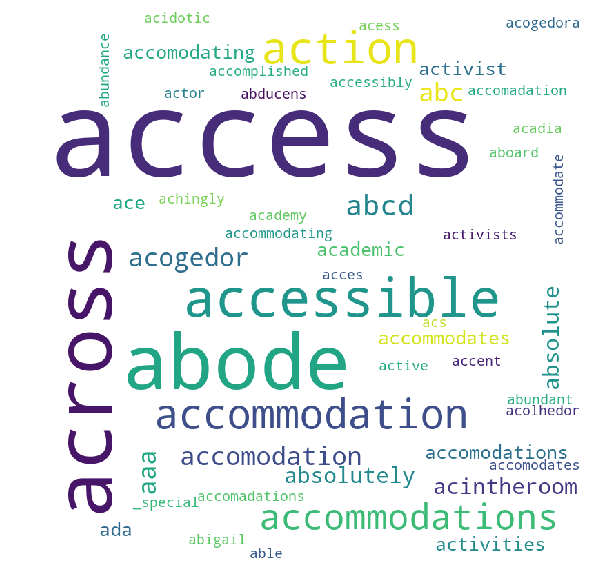

In [9]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
%matplotlib inline

wc_data = word_popularity[0:50, :].as_data_frame(use_pandas=True) # graph top 50 words
wc_data = dict(zip(wc_data.Word, wc_data.Count))

  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10)
wordcloud.generate_from_frequencies(wc_data) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Word2Vec

Now we can train our Word2Vec model to convert each word to a numeric vector.  Words with numeric vectors that are close to each other are considered synonyms.

In [10]:
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_model = H2OWord2vecEstimator(model_id = "w2v.hex")
w2v_model.train(training_frame=name)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [108]:
# Sanity check - find synonyms for the word 'cozy'
w2v_model.find_synonyms("cozy", count = 5)

OrderedDict([('beautiful', 0.6701868772506714),
             ('cosy', 0.6489199995994568),
             ('lovely', 0.6105824708938599),
             ('peaceful', 0.5992908477783203),
             ('cute', 0.5975832939147949)])

In [109]:
# Sanity check - find synonyms for the word 'doorman'
w2v_model.find_synonyms("doorman", count = 5)

OrderedDict([('stately', 0.8093443512916565),
             ('dapper', 0.8052889108657837),
             ('sundeck', 0.7950878143310547),
             ('bespoke', 0.7659077048301697),
             ('blueground', 0.7494929432868958)])

### Visualizing Words

We can visualize the words using the word embeddings from Word2Vec.  Words that are close together should be related.

To visualize the words, we will first get the word embedding for each word and reduce the dimensionality of the word embedding from 100 to 2 using Principal Component Analysis.  We reduce the dimensionality to 2 since this is easier to see in a graph.

In [11]:
# Get embeddings for each word
word_popularity["Word"] = word_popularity["Word"].ascharacter()
word_embeddings = w2v_model.transform(word_popularity["Word"], aggregate_method=None)
word_embeddings = word_popularity.cbind(word_embeddings)
word_embeddings = word_embeddings[~word_embeddings["C1"].isna()]

In [111]:
word_embeddings.head()

Word,Count,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
abcd,5,-0.014784,-0.0448724,0.0727337,0.0618825,-0.104638,0.100871,0.0214725,-0.014579,-0.0225959,-0.254917,-0.236205,-0.04611,0.273484,-0.130235,-0.0648934,0.0626667,-0.231698,-0.0185529,-0.188289,0.145368,0.0275452,0.0497404,-0.02233,0.0407892,0.0779981,0.135516,-0.273602,0.00481724,0.244164,0.0163477,-0.0922894,0.154502,-0.0712219,-0.0250663,0.0383247,-0.120466,-0.0751503,0.0564279,0.0433635,-0.0521454,-0.0831919,-0.0773358,-0.0559675,-0.0972525,-0.0411622,-0.119867,0.0745074,-0.0556692,-0.237852,0.0126236,-0.0460122,-0.0128052,-0.079168,0.0560173,0.20164,0.0849538,-0.0657991,-0.0881585,0.148331,-0.0134764,-0.0810217,-0.026782,0.272207,-0.0145905,0.0656313,-0.253206,0.198488,0.0455507,-0.0127142,-0.206405,-0.00924419,0.0909968,-0.0746076,-0.130821,-0.00354418,-0.0322867,0.0500652,-0.0477673,0.0964944,0.0968274,-0.0201248,-0.0320025,0.147105,-0.0225689,-0.10282,0.105063,-0.137723,0.15963,-0.0816883,0.0264359,-0.0862836,-0.0354567,0.0963034,0.0801499,-0.0912222,-0.134032,0.121643,0.0672233,-0.035652,-0.248933
abode,51,-0.345532,-0.0925766,-0.128552,-0.266802,-0.269182,0.0461995,0.0827727,-0.391479,0.0394319,-0.282097,-0.0263401,-0.418604,0.192107,0.232227,-0.0857925,0.495368,0.128523,-0.23834,-0.0466376,0.119474,0.114378,0.0310884,0.0499499,-0.237633,-0.231084,0.106973,-0.0909885,0.216717,0.234416,-0.00317142,-0.259715,-0.150372,-0.106567,0.148665,0.297576,0.0150642,-0.00941948,0.355335,0.11603,0.133273,0.0700324,-0.263749,-0.0885329,-0.0313624,-0.263201,-0.0909564,0.10058,-0.149051,-0.317049,0.0386038,-0.188221,-0.00397031,-0.354285,0.0445647,-0.161669,-0.0569229,0.114009,-0.217492,0.0195269,0.220075,-0.39763,-0.0261614,0.227029,0.261703,-0.00485862,0.0962957,0.115548,0.00229503,0.0400579,-0.340555,0.300592,0.166434,-0.00567433,-0.225401,-0.0814473,-0.402561,0.129173,-0.143706,0.250224,0.0158399,0.193291,-0.188033,0.334704,-0.227526,0.0876686,0.345983,0.142706,0.1181,-0.165731,0.031471,-0.124339,-0.170275,-0.0148769,0.235368,0.0478807,-0.147204,0.380205,-0.0560069,0.024704,-0.162484
access,177,0.243396,0.127061,0.492417,0.500696,0.155584,0.266068,-0.506194,0.0174209,-0.1003,-0.378945,-0.192098,0.265729,0.310253,0.0233236,-0.16822,-0.235653,-0.299058,-0.237443,0.135653,0.21933,0.125275,0.559838,-0.404598,0.527993,0.324777,0.236468,-0.0586135,0.286679,0.332082,-0.389589,-0.086875,0.122288,-0.186958,0.138657,-0.348386,-0.144878,-0.136365,0.280353,0.354191,-0.0842651,-0.211375,-0.333888,0.0846192,-0.089836,0.597241,0.319296,0.348665,0.00839959,-0.337462,-0.148813,0.0656222,-0.0117134,0.500912,0.189681,0.495752,-0.126929,0.405832,-0.0173107,-0.520914,0.133396,-0.0810095,0.326322,-0.376555,0.109909,0.124088,-0.532666,0.0933707,0.757157,-0.447472,-0.332801,0.343645,-0.176449,-0.52396,-0.315943,-0.113406,0.0058034,0.292631,-0.167962,-0.0359875,0.657981,0.079078,0.401016,-0.0579181,-0.373819,-0.0323866,-0.062582,-0.651068,0.406629,0.00850418,-0.254789,-0.144054,-0.186457,-0.00230173,0.621397,-0.107434,0.0469877,0.339541,-0.121722,0.145845,-0.126617
accessible,20,0.131989,0.0647159,0.105839,-0.0303294,0.078532,-0.0926667,0.234091,-0.024495,0.186743,-0.128822,-0.128554,-0.141252,0.110926,-0.0581673,-0.142581,0.110602,-0.400442,0.0077483,-0.253511,0.0783279,0.1778,-0.229583,0.114954,0.10374,-0.00134171,-0.0428497,-0.0459456,-0.0851026,0.114999,0.102765,-0.0510281,0.0932171,-0.264183,0.0301225,-0.261817,0.00585949,-0.205425,-0.0431247,-0.0367284,-0.0342615,-0.157541,-0.0834701,-0.0250501,-0.011359,0.0451838,0.0550776,-0.0876698,-0.0279738,-0.132142,-0.0123063,0.197021,-0.106004,-0.185084,-0.0371187,0.167013,0.163794,0.0397188,0.00434011,0.189

In [165]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_embeddings(word_embeddings, x, sort_column="Count", num_words_plotted=50):

    num_words_plotted = min(num_words_plotted, word_embeddings.nrow)
    
    # Reduce the dimensionality of the word embeddings to 2 for plotting
    from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator

    pca = H2OPrincipalComponentAnalysisEstimator(model_id="pca.hex", k=2, impute_missing=True)
    pca.train(training_frame=word_embeddings[x])
    
    # Get top words by popularity and convert to pandas
    not_x = [i for i in word_embeddings.col_names if i not in x]
    plot_data = word_embeddings[not_x].cbind(pca.predict(word_embeddings))
    plot_data = plot_data.sort(sort_column, ascending=False)[0:num_words_plotted, :].as_data_frame(use_pandas=True)
    
    # Plot the words
    figure(num=None, figsize=(10, 10), dpi=80)
    plt.scatter(plot_data.PC1, plot_data.PC2)
    for i in range(len(plot_data)):
        label = plot_data.iloc[i]["Word"]
        plt.annotate(label, 
                     (plot_data.iloc[i]["PC1"], plot_data.iloc[i]["PC2"]), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center') 
        
    return plt
    

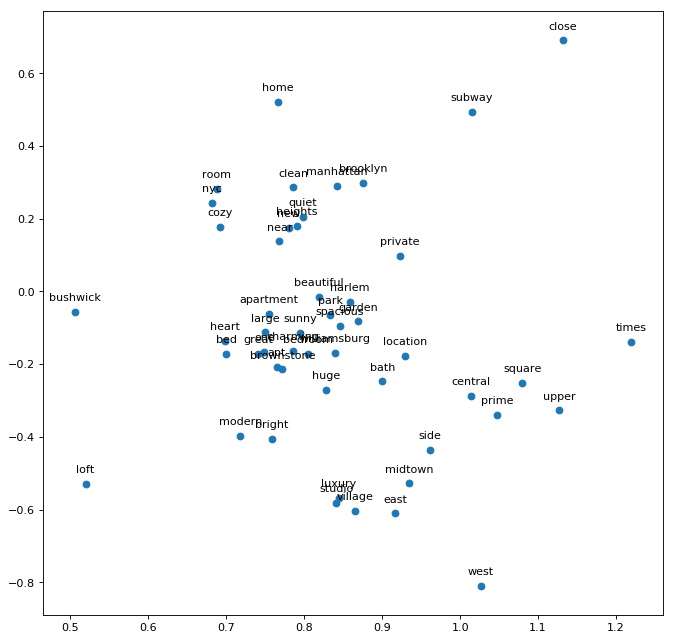

In [172]:
word_plot = plot_embeddings(word_embeddings, ["C{}".format(i) for i in range(1, 101)])
word_plot.show()

### Topic Modeling

We can also use the word embeddings to find topics in the data.  We will use H2O-3's KMeans algorithm to find natural clusters of words and extract.

In [206]:
# Train KMeans to find natural clusters of words
from h2o.estimators.kmeans import H2OKMeansEstimator

kmeans = H2OKMeansEstimator(model_id="word_clusters.hex", 
                            k=5, # 10 topics
                            seed=1234
                           )
kmeans.train(training_frame=word_embeddings[2::])

In [207]:
# Add cluster column
cluster_assignment = kmeans.predict(word_embeddings)
cluster_assignment.col_names = ["Cluster"]
cluster_assignment.table()

Cluster,Count
0,736
1,491
2,11
3,28
4,282


We will define the topics of the cluster as the words that have the greatest popularity and are closest to the cluster center.

We define a function that gets the topic for us.

In [210]:
def get_topic(word_embeddings, kmeans, cluster_id):
    
    h2o.no_progress()
    
    # Get words in cluster
    cluster = kmeans.predict(word_embeddings)
    cluster = word_embeddings[cluster["predict"] == cluster_id]
    
    # Get cluster center
    center = h2o.H2OFrame([kmeans.centers()[cluster_id]])
    center_distance = cluster[2:].distance(center)
    center_distance.col_names = ["Center_Distance"]
    
    topic = cluster.cbind(center_distance)
    
    return plot_embeddings(topic, x=["C{}".format(i) for i in range(1, 101)], sort_column="Center_Distance", num_words_plotted=20)
    

### Cluster 0

The words in cluster 0 show that the topic represents listings that are in some expensive Manhattan and Brooklyn neighborhoods.

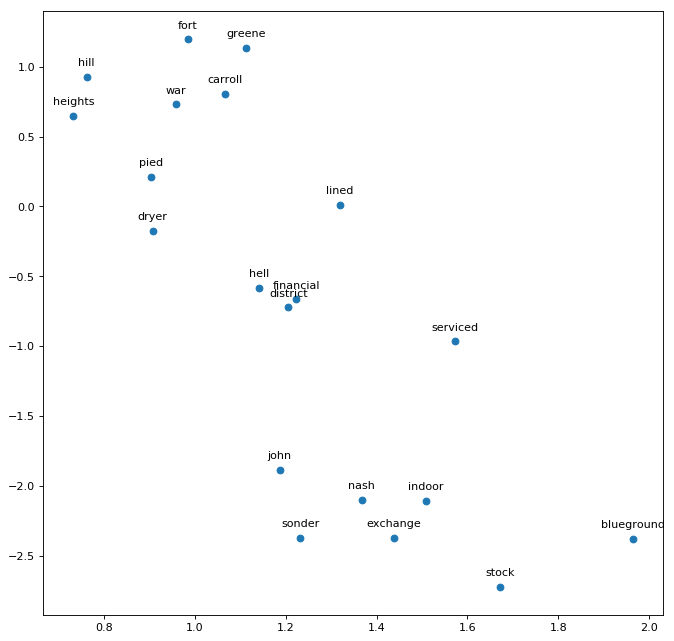

In [217]:
get_topic(word_embeddings, kmeans, 0).show()

### Cluster 1

The words in cluster 1 show that the topic represents listings in that have access to gardens/forest and maybe are in close proximity to Long Island.

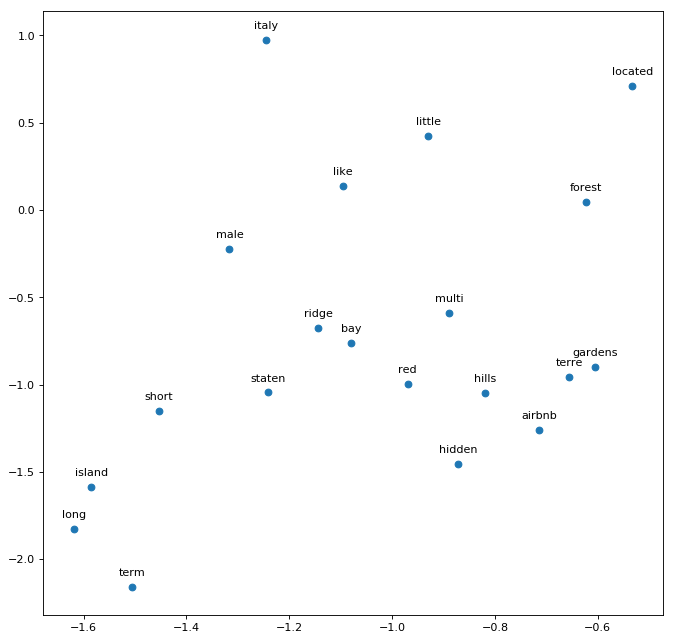

In [218]:
get_topic(word_embeddings, kmeans, 1).show()

### Cluster 2

The words in cluster 2 show that the topic represents listings that are in certain neighborhoods in Brooklyn, Manhattan, and Queens.

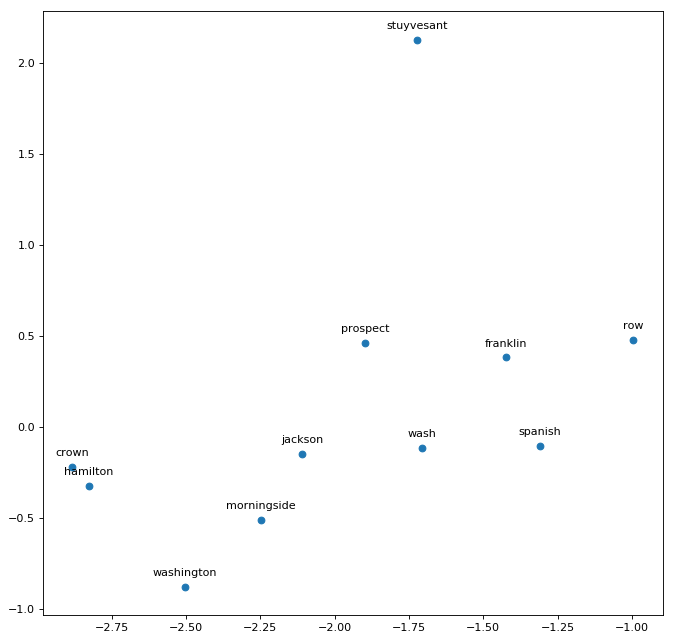

In [219]:
get_topic(word_embeddings, kmeans, 2).show()

### Cluster 3

The words in cluster 3 show that the topic represents luxury listings.

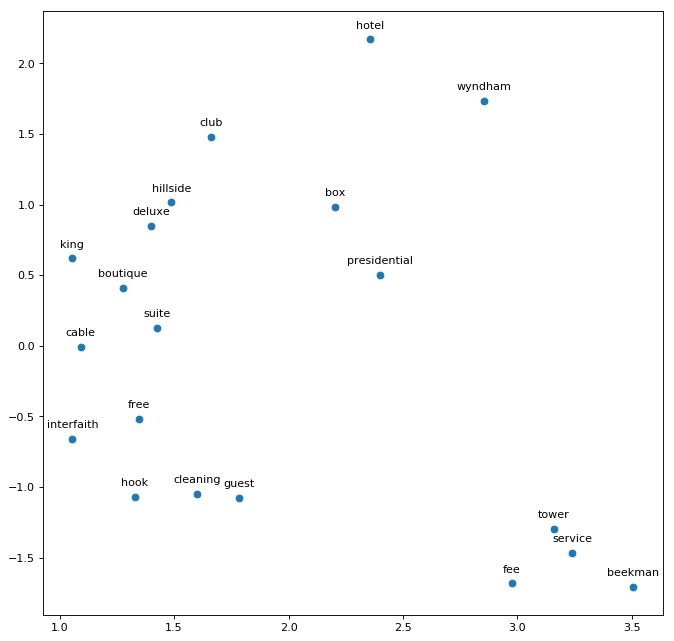

In [220]:
get_topic(word_embeddings, kmeans, 3).show()

### Cluster 4

The words in cluster 4 show that the topic represents listings that are close to attractions like yankee stadium and universities.

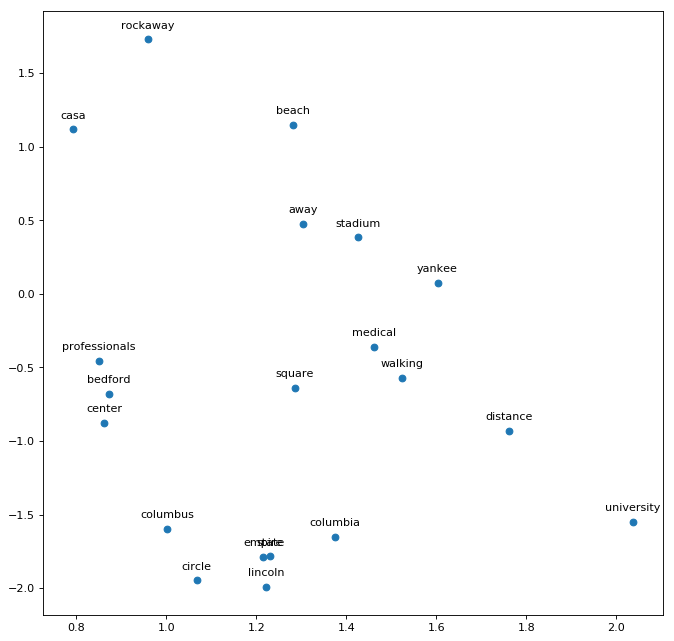

In [221]:
get_topic(word_embeddings, kmeans, 4).show()

## Training Models with Text

Now that we have analyzed our text column, we will use the word embedidngs as features in a supervised learning model to predict price.

We will take the word embeddings that belong to each word in a listing and average them so that there is one aggregated word embedding per listing.

In [119]:
ext_airbnb = airbnb.cbind(w2v_model.transform(name, aggregate_method = "AVERAGE"))
ext_airbnb.head()

id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.6475,-73.9724,Private room,149,1,9,2018-10-19 00:00:00,0.21,6,365,-0.0779883,-0.0891714,0.0598615,-0.0509085,-0.0171792,0.0462776,0.0763733,-0.0838036,0.0309917,-0.159643,-0.168767,0.00174896,0.0534047,-0.00561104,-0.0568902,0.123215,-0.122753,0.0656544,-0.0476102,0.0686766,0.288189,-0.166636,0.0810076,0.0561222,-0.121805,0.0441583,-0.210229,0.20506,0.257178,-0.0044853,0.0317514,0.0612426,0.115552,-0.00454928,0.0300171,-0.186813,-0.0694377,0.145015,-0.10764,-0.044605,0.0291893,0.0194209,-0.09838,-0.170175,-0.095955,-0.0802319,0.0164796,-0.101964,-0.155014,-0.136125,-0.0224187,-0.000908518,-0.206903,-0.0608924,0.128243,0.0142872,0.0312154,-0.173468,0.188637,-0.00249839,-0.0444169,0.0518356,0.125001,-0.0388271,-0.0400839,-0.160812,0.0398344,0.0545787,0.013759,-0.418553,-0.0304176,0.225353,-0.0501585,-0.150144,-0.038855,-0.192255,0.0440559,-0.138209,0.196892,0.0619943,-0.155924,-0.0812479,0.0661097,-0.12246,-0.0230999,0.228684,0.0466856,0.183558,-0.08252,0.082705,-0.174698,-0.0779357,0.077069,0.089857,-0.0967349,-0.181167,-0.0215279,0.00219584,0.0875834,-0.182469
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.7536,-73.9838,Entire home/apt,225,1,45,2019-05-21 00:00:00,0.38,2,355,0.0688603,0.0387977,-0.0373551,0.0108541,0.0742104,0.00824431,0.0818572,-0.0378633,0.192882,-0.259747,-0.0942923,-0.0525531,0.0644426,-0.0497492,0.0846405,0.00301643,-0.179683,-0.00240753,0.0793921,-0.076384,0.0956536,0.028354,0.0761743,-0.0644976,-0.0098003,-0.130104,-0.0575697,0.049658,0.0660548,0.14491,-0.0800747,0.142989,-0.140257,0.0103882,-0.160429,-0.0851101,-0.0668482,0.120716,0.0281441,0.0514033,-0.070696,-0.0233068,-0.179796,0.00564342,-0.0086486,-0.0918312,-0.0343491,-0.00811109,0.0268101,-0.108355,0.022281,-0.117629,-0.0952704,0.039139,0.22708,-0.0163698,0.0474497,-0.0506368,-0.0924003,-0.286729,0.0883758,-0.0124707,0.14044,-0.1387,-0.120306,-0.070015,0.0194431,-0.0392136,-0.184008,-0.00667669,-0.0373984,0.0766335,-0.0752549,-0.200874,-0.0165937,0.0128909,-0.0559741,-0.0606038,0.138012,0.0662257,-0.185819,0.0172771,0.207013,-0.0428637,-0.164044,0.139027,-0.249388,0.181988,0.0588455,0.16371,-0.146246,-0.0864407,0.139687,-0.0809625,-0.0762463,0.034388,0.0697717,0.0457043,0.0775023,-0.0728703
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.809,-73.9419,Private room,150,3,0,,nan,1,365,0.0852412,0.0947486,-0.0596483,-0.082053,-0.194784,-0.0497654,0.16678,-0.151064,0.0602588,-0.289385,-0.136092,-0.280291,-0.135689,0.112589,-0.0165828,0.142836,-0.500221,-0.0773841,0.121382,-0.116524,0.00986774,0.251817,0.0882369,-0.267462,0.0293487,0.0518095,0.0993715,-0.116402,-0.00785418,0.0558467,0.13888,0.142497,0.134613,0.0251953,-0.0899272,-0.0319453,-0.189802,0.127992,0.314002,0.0409794,-0.212283,0.257725,-0.317312,-0.156435,-0.0335773,-0.159595,0.176733,0.00021092,0.110189,-0.286927,0.122109,-0.102152,-0.348587,0.000728537,0.0347407,-0.12316,-0.00454184,-0.151914,0.114321,-0.204185,-0.0240741,-0.315082,0.14245,-0.0639845,0.011471,0.0118112,0.0494506,0.0325932,-0.110691,-0.019006,0.106946,0.100814,0.084397,-0.0289361,-0.0969835,0.139265,0.0305875,-0.34126,0.0550694,0.116466,-0.422923,-0.0601918,0.194818,-0.096354,-0.217341,0.0515934,0.180577,-0.00967253,0.0854191,0.217939,0.008639,-0.0929745,0.149659,0.162607,-0.409865,-0.128484,0.143349,-0.0381493,0.09303,-0.0

Now we will run AutoML to find the best algorithm and parameters of that algorithm.

In [120]:
# Run AutoML to get 5 models - this is a small number for demo purposes
from h2o.automl import H2OAutoML

x = list(set(ext_airbnb.col_names) - set(["price", "id", "host_name"]))
auto_ml = H2OAutoML(max_models=5, 
                    seed=1234, 
                    nfolds=3,
                    sort_metric="MAE", 
                    project_name="airbnb",
                    include_algos=["GBM", "XGBoost", "GLM"]
                   )
                    
auto_ml.train(x=list(set(x) - set(["name"])), y="price", training_frame=ext_airbnb)

In [121]:
auto_ml.leaderboard

model_id,mae,mean_residual_deviance,rmse,mse,rmsle
XGBoost_2_AutoML_20200707_131729,63.2002,46918.3,216.606,46918.3,nan
XGBoost_1_AutoML_20200707_131729,63.8126,47443.6,217.816,47443.6,nan
XGBoost_3_AutoML_20200707_131729,64.8888,48617.1,220.493,48617.1,0.500043
GBM_1_AutoML_20200707_131729,66.5074,50912.3,225.638,50912.3,nan
GLM_1_AutoML_20200707_131729,70.9775,50161.4,223.967,50161.4,nan


In [123]:
best_model = auto_ml.leader

Below is the variable importance of our best model.  We can see that the word emebeddings are among the top variables.

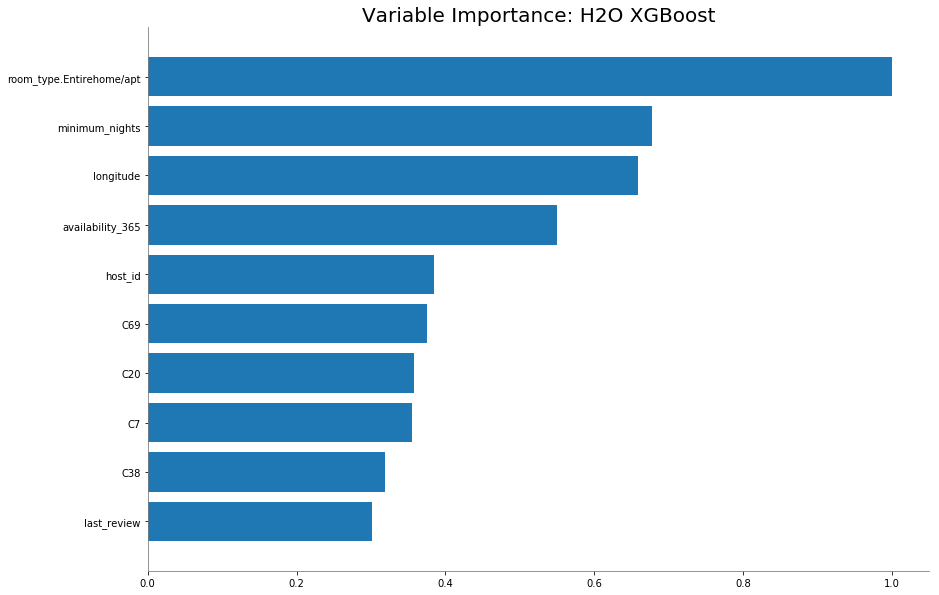

In [124]:
best_model.varimp_plot()

The partial dependence plot for `C69` shows us that listings with high `C69` value have a higher price prediction.


PartialDependence: Partial Dependence Plot of model XGBoost_2_AutoML_20200707_131729 on column 'C69'


,c69,mean_response,stddev_response,std_error_mean_response
0,-0.583054,153.709187,120.852451,0.546542
1,-0.511015,153.709187,120.852451,0.546542
2,-0.438976,153.709187,120.852451,0.546542
3,-0.366938,153.709187,120.852451,0.546542
4,-0.294899,150.767991,122.249381,0.552859
5,-0.222861,149.756633,122.443137,0.553735
6,-0.150822,149.275402,122.291166,0.553048
7,-0.078783,148.861402,122.030298,0.551868
8,-0.006745,148.569403,121.875370,0.551168
9,0.065294,148.606023,121.931312,0.551421


[]

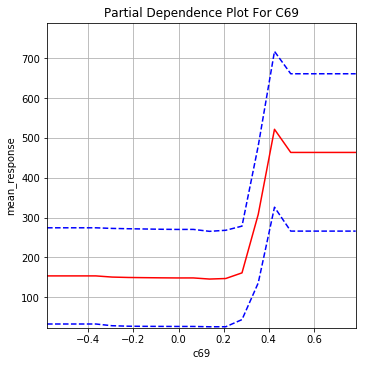

In [143]:
best_model.partial_plot(ext_airbnb, cols=["C69"], figsize=(5, 5))

We can see that there is a jump in price prediction if `C69` is greater than 0.4.  We can graph the top and bottom words by `C69` below using matplotlib.  Words like `exposed` (exposed brick?) and `gardens` have the highest values.

In [12]:
def plot_topbottom_words(word_embeddings, var, num_words=10):
    
    sorted_embeddings = word_embeddings[["Word", var]].sort(var)
    top_words = sorted_embeddings[:num_words, :]
    top_words["color"] = "red"
    
    bottom_words = sorted_embeddings[-num_words:, :]
    bottom_words["color"] = "green"
    
    plot_data = top_words.rbind(bottom_words).as_data_frame(use_pandas=True)
    
    plt.bar(plot_data.Word, plot_data[var], color = plot_data.color)
    plt.xlabel("Word")
    plt.ylabel(var)
    plt.title("Top and Bottom Words by {}".format(var))
    plt.xticks(rotation='vertical')

    return plt  

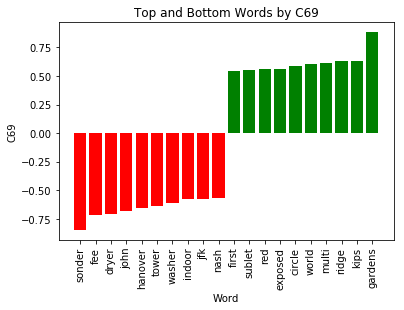

In [13]:
plot_topbottom_words(word_embeddings, "C69").show()

In [14]:
h2o.cluster().shutdown()

H2O session _sid_8693 closed.
